## Emissions estimator

The objective of this additional notebook is to build a neural network aimed at predicting the missing values from the column 'Emissions' of the original dataset.

##### Imports

In [1]:
import sys
sys.path.insert(0, '../')
from core_functions import *
from pandas import set_option
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings("ignore")

#### Load data

We load our dataset.

In [2]:
# Load dataset
df = pd.read_csv('../data/auto_price.csv', sep=',')

We immediately build a sub-dataframe, with all the columns that could be useful for our scope.

In [3]:
emission_df = df[['MatriculationYear', 'cv', 'Engine', 'Emissions', 'Consume', 'EmissionClass']].copy()

#### Preprocess our data

##### Consume column

Thanks to the 'consume_numerizer' function, we extract the numerical value from the 'Consume' column.

In [4]:
emission_df['Consume'] = emission_df['Consume'].apply(consume_numerizer)

##### EmissionClass column

Thanks to the snippet below, we estimate the emission class of each car in the dataset, and fill the relative column.

In [5]:
for idx, row in emission_df.iterrows():
    if type(row['EmissionClass'])!=str:
        inferred_emission_class = check_emission_class(row['EmissionClass'], row['MatriculationYear'])
        emission_df.loc[idx, 'EmissionClass'] = inferred_emission_class
emission_df.isna().sum()

MatriculationYear        0
cv                   11315
Engine                8350
Emissions            55438
Consume              46437
EmissionClass            0
dtype: int64

Map the categorical values in reversed order. The assumption is that a higher class implies a lower emission value.

In [6]:
emission_map = {'Euro 0':6, 'Euro 1':5, 'Euro 2':4, 'Euro 3':3, 'Euro 4':2, 'Euro 5':1, 'Euro 6':0}
emission_df['EmissionClass'] = emission_df['EmissionClass'].map(emission_map).astype('int')

#### Outliers detection

Let's filter out all the values equal or lower than 1cv, because I personally think these are errors, while for higher cv I cannot be so sure, so I will keep them.</br>
Additionally, also values for the 'Engine' feature that are below 50 will be deleted.

The percentage of missing values is the following: 

 MatriculationYear     0.00
cv                    6.35
Engine                4.68
Emissions            31.10
Consume              26.05
EmissionClass         0.00
dtype: float64 


Old Shape:  (178248, 6)


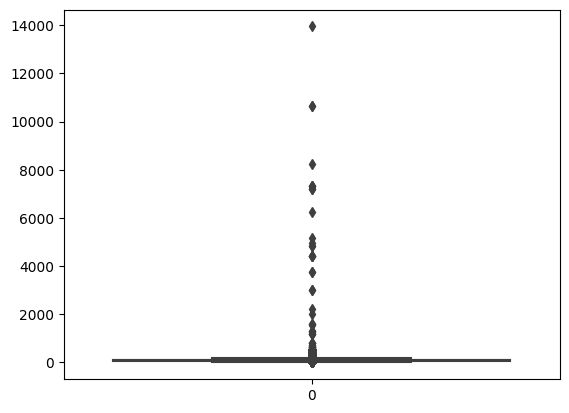

New Shape:  (162756, 6)


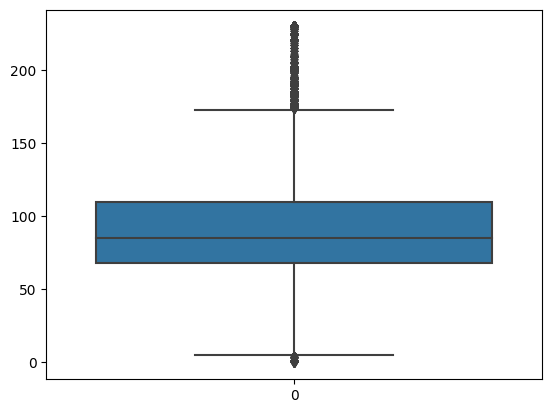

The percentage of missing values is the following: 

 MatriculationYear     0.00
cv                    0.00
Engine                4.00
Emissions            26.37
Consume              21.09
EmissionClass         0.00
dtype: float64 


We lost the 8.69% of the initial observations.
The percentage of missing values is the following: 

 MatriculationYear     0.00
cv                    0.00
Engine                3.84
Emissions            26.19
Consume              20.90
EmissionClass         0.00
dtype: float64 


Old Shape:  (162309, 6)


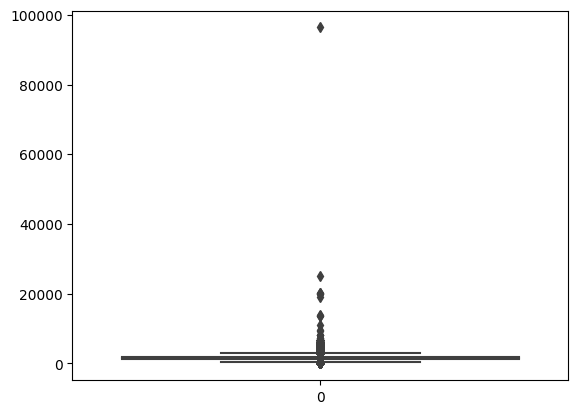

New Shape:  (155526, 6)


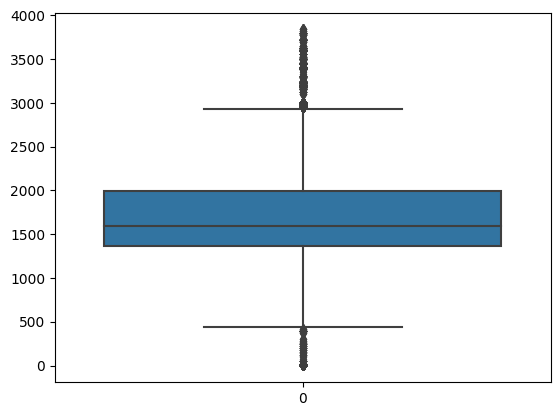

The percentage of missing values is the following: 

 MatriculationYear     0.00
cv                    0.00
Engine                0.00
Emissions            24.50
Consume              17.96
EmissionClass         0.00
dtype: float64 


We lost the 12.75% of the initial observations.
The percentage of missing values is the following: 

 MatriculationYear     0.00
cv                    0.00
Engine                0.00
Emissions            21.86
Consume              17.84
EmissionClass         0.00
dtype: float64 


Old Shape:  (150256, 6)


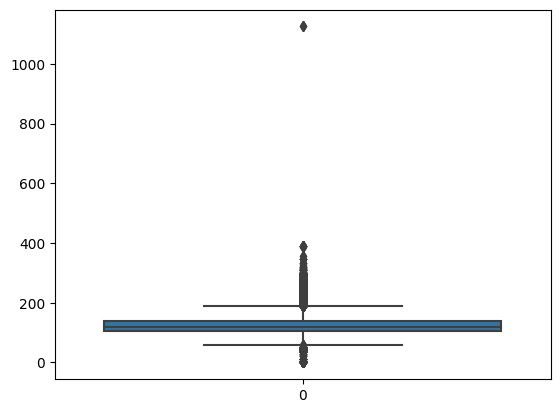

New Shape:  (111284, 6)


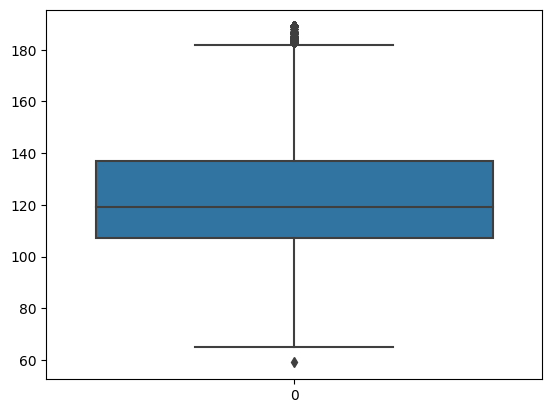

The percentage of missing values is the following: 

 MatriculationYear    0.00
cv                   0.00
Engine               0.00
Emissions            0.00
Consume              3.75
EmissionClass        0.00
dtype: float64 


We lost the 37.57% of the initial observations.


In [7]:
#outliers_deletion(emission_df, 'Consume')
outliers_deletion(emission_df, 'cv')
threshold = 1
# create a boolean mask of rows to keep
mask = emission_df['cv'] > threshold
# apply the mask to the dataframe
emission_df = emission_df[mask]

outliers_deletion(emission_df, 'Engine')
threshold = 50
# create a boolean mask of rows to keep
mask = emission_df['Engine'] >= threshold
# apply the mask to the dataframe
emission_df = emission_df[mask]

outliers_deletion(emission_df, 'Emissions', threshold=1.5)

For the consume column, the IQR seems not to be a good way.</br
Seen that there are some definitely too high values (such a consume of 6000l/km) and that the mean is around 5, by using the IQR method we would likely remove also values such as 12l/100km, which is a pretty standard value that doesn't need to be deleted.</br>
In order to solve this problem, I will manually define a threshold, over which all values are likely to be errors.

In [8]:
threshold = 25
# create a boolean mask of rows to keep
mask = emission_df['Consume'] <= threshold
# apply the mask to the dataframe
consume_df = emission_df[mask]

#### Prepare for training

Split into feature and target dataset.

We drop the rows containing NaN values.

In [9]:
filled_df = emission_df[['Consume', 'cv', 'Engine', 'EmissionClass', 'Emissions']].dropna()

In [10]:
X = filled_df[['Consume', 'cv', 'Engine', 'EmissionClass']]
y = filled_df['Emissions'].astype(int)

print(X.shape, y.shape)

(107114, 4) (107114,)


We scale the features' dataset thanks to the sklearn.StandardScaler.

In [11]:
standard_scaler = preprocessing.StandardScaler()
X = standard_scaler.fit_transform(X)

In [12]:
X

array([[-0.03338806, -0.20799978,  0.82230366,  0.63039088],
       [ 0.08603504, -0.50852838, -0.15036371,  1.94571908],
       [-0.04494514, -0.35826408, -0.47620728,  0.63039088],
       ...,
       [-0.04494514, -0.20799978, -0.39109888, -0.68493732],
       [-0.04494514, -0.20799978, -0.39109888, -0.68493732],
       [-0.03338806,  0.54332173,  0.82230366, -0.68493732]])

Split into training and test dataset.

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [14]:
# Shapes of our data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(71766, 4) (71766,)
(35348, 4) (35348,)


#### Neural Network Model

We build two callback functions:
- <b>earlystopping</b> is aimed at interrupting the training if the model stops learning. Additionally, it saves the best weight configuration reached during training;
- <b>reduce_lr</b> is useful to define a dynamic learning rate for our model. The lr is reduced when the model gets stuck on a plateu during training.

In [15]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="auto", patience = 12, 
                                        restore_best_weights = True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                        patience=5, min_lr=0.0000001)

We build our NN model. The model is not too complex, but reasonably deep, and with some skip connections. As you can see, it is made up of mainly dense layers, the loss function used to train it is the MAE (Mean Absolute Error), but the metric we look at is the MSE (Mean Squared Error), to have a grasp on the capability of generalizing results. Reaching a low MAE value is per-se a finish line for the training, in particular if it is accompanied by a relatively low MSE value.</br>
Since the initial drafts where overfitting, I have added a Dropout layer with probability 0.2.

In [16]:
######################################
# Model Name = emissions_estimator
######################################

# Define optimizer and initial learning rate
optimizer = Adam(learning_rate=0.03) # The initial learning rate is pretty high, but it gets dynamically decreased during training steps

input_layer = Input(shape=(4,))

# Define Hidden layers
first_dense_layer = Dense(32, activation='swish', kernel_initializer=initializers.GlorotUniform())(input_layer) # was swish 16
second_dense_layer = Dense(32, activation = 'relu', kernel_initializer=initializers.GlorotUniform())(input_layer) # was selu 16

concatenated_layer = concatenate([first_dense_layer, second_dense_layer])
dropout_layer_1 = Dropout(0.2)(concatenated_layer)

third_dense_layer = Dense(8, activation = 'selu', kernel_initializer=initializers.GlorotUniform())(concatenated_layer) # 8

skip_layer = Dense(8, activation='swish', kernel_initializer=initializers.GlorotUniform())(second_dense_layer)

concatenated_layer_2 = concatenate([third_dense_layer, skip_layer])

final_dense_layer = Dense(8, activation = 'relu', kernel_initializer=initializers.GlorotUniform())(concatenated_layer_2) # 4 was selu

# Output Dense layer
output = Dense(1, activation='relu')(final_dense_layer)

# Build and compile the model
emissions_estimator = Model(inputs=input_layer, outputs=output)
emissions_estimator.compile(optimizer=optimizer, loss='mae', metrics=['mse'])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-22 02:05:39.694552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-22 02:05:39.694654: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Here we print out a summary of our model.

In [17]:
emissions_estimator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           160         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 32)           160         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 64)           0           ['dense[0][0]',                  
                                                                  'dense_1[0][0]']            

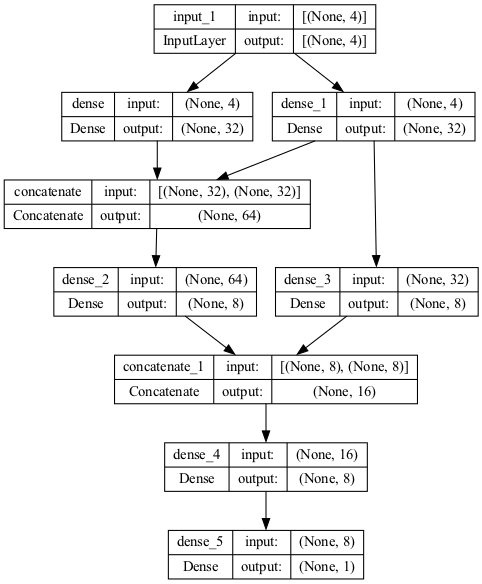

In [18]:
plot_model(emissions_estimator, show_shapes=True, dpi=76)

#### Training

We define some hyper-parameters for the training.

In [19]:
batchsize = 128
epochs = 100
steps_per_epoch = 1000 
validation_steps = 500 

Effective training.

In [20]:
# Training record
################################################################################

history = emissions_estimator.fit(X_train,
                            y_train,
                            steps_per_epoch=steps_per_epoch, 
                            validation_split=0.2, 
                            epochs=epochs,
                            shuffle=True, 
                            callbacks =[reduce_lr, earlystopping])

Epoch 1/100


2023-03-22 02:05:40.380522: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-22 02:05:40.637986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 996/1000 [============================>.] - ETA: 0s - loss: 6.3150 - mse: 1552.3027

2023-03-22 02:05:51.186515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - 13s 12ms/step - loss: 6.3043 - mse: 1546.2294 - val_loss: 4.5403 - val_mse: 105.3802 - lr: 0.0300
Epoch 2/100
1000/1000 [==============================] - 12s 12ms/step - loss: 3.6002 - mse: 377.1084 - val_loss: 3.4255 - val_mse: 33.1266 - lr: 0.0300
Epoch 3/100
1000/1000 [==============================] - 12s 12ms/step - loss: 3.2910 - mse: 54.7070 - val_loss: 2.8307 - val_mse: 27.2001 - lr: 0.0300
Epoch 4/100
1000/1000 [==============================] - 12s 12ms/step - loss: 3.0902 - mse: 27.1277 - val_loss: 3.1954 - val_mse: 29.0614 - lr: 0.0300
Epoch 5/100
1000/1000 [==============================] - 12s 12ms/step - loss: 3.0485 - mse: 30.0991 - val_loss: 3.1376 - val_mse: 28.3888 - lr: 0.0300
Epoch 6/100
1000/1000 [==============================] - 12s 12ms/step - loss: 2.9168 - mse: 25.2809 - val_loss: 3.1039 - val_mse: 25.5077 - lr: 0.0300
Epoch 7/100
1000/1000 [==============================] - 12s 12ms/step - loss: 2.8179 - mse: 24.

As we can see, the value of the MSE (around 19) is pretty high in the validation set, but the MAE is around 1.8 points. This is yet a good result. It is way better than imputing manually with mean or median values, the column.

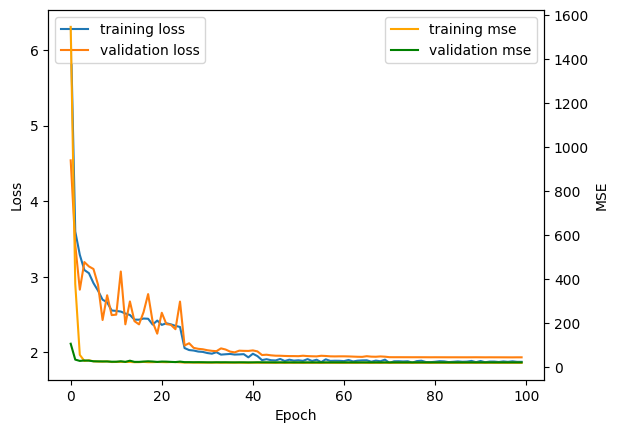

In [23]:
plot_training_history(history)

Let's save the model.

In [21]:
emissions_estimator.save("models/emissions_estimator_4dim")

INFO:tensorflow:Assets written to: models/emissions_estimator_4dim/assets


### Test

The aim of this section is to test our model against the test_set (that it has never seen), in order to have a clearer idea about the performances.

In [22]:
estimator = keras.models.load_model("models/emissions_estimator_4dim")